In [146]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# Preprocess imports
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Vectorization imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model imports
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, log_loss, ConfusionMatrixDisplay, accuracy_score, \
    precision_score, recall_score, f1_score, roc_auc_score

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Load the Spacy model
nlp = spacy.load('en_core_web_sm')

In [191]:
df = pd.read_csv('sentiment_df.csv')
df

,date,user,tweet,likes,replies,retweets,hashtags,user_id,topic,year,clean_tweet,sentiment
0,2020-06-07 21:50:52+00:00,brittany_broski,Next up on the docket: free every black man un...,542202,938,148464,[],1262905431602589696,legalization,2020,next docket free every black man unfairly rott...,Positive
1,2020-11-04 23:49:38+00:00,AOC,Shout out to the hard work of grassroots organ...,289942,1573,18519,[],138203134,legalization,2020,shout hard work grassroots organizers successf...,Positive
2,2020-07-28 13:21:06+00:00,MargBarAmerica,i still can't get over the democrats overwhelm...,24154,156,1975,[],17109158,legalization,2020,still can t get democrats overwhelmingly votin...,Negative
3,2020-12-04 18:27:14+00:00,nytimes,The House has voted to decriminalize marijuana...,18705,715,5606,[],807095,legalization,2020,house voted decriminalize marijuana expunge no...,Neutral
4,2020-07-28 12:57:33+00:00,YesYoureRacist,Good morning! 57% of Americans and 78% of Demo...,15003,117,4613,[],858924511,legalization,2020,good morning 57 americans 78 democrats support...,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
152451,2015-12-29 13:21:28+00:00,lanceb62,Soros Foundation promoted drug legalization wo...,1,0,1,[],2874372175,drug legalization,2015,soros foundation promoted drug legalization wo...,Neutral
152452,2015-10-17 15:05:00+00:00,JamieGump,Waiting to hear @TexasGOP say anything about #...,1,0,0,"['druglegalization', 'ttf', 'bordersecurity']",528261651,drug legalization,2015,waiting hear texasgop say anything druglegaliz...,Neutral
152453,2015-10-23 12:37:56+00:00,KerryWMartin,"""Police work for #narcos because they pay bett...",0,1,0,"['narcos', 'druglegalization']",2545495004,drug legalization,2015,police work narcos pay better interview drugle...,Neutral
152454,2015-08-01 01:10:26+00:00,PunkRockLiberty,Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...,0,0,1,[],1278031291,drug legalization,2015,govt funded anti drug program d a r e called l...,Neutral


In [192]:
df = df[['tweet', 'topic']]
df

,tweet,topic
0,Next up on the docket: free every black man un...,legalization
1,Shout out to the hard work of grassroots organ...,legalization
2,i still can't get over the democrats overwhelm...,legalization
3,The House has voted to decriminalize marijuana...,legalization
4,Good morning! 57% of Americans and 78% of Demo...,legalization
...,...,...
152451,Soros Foundation promoted drug legalization wo...,drug legalization
152452,Waiting to hear @TexasGOP say anything about #...,drug legalization
152453,"""Police work for #narcos because they pay bett...",drug legalization
152454,Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...,drug legalization


In [6]:
def train_and_evaluate(models):
    # Train and evaluate each model
    accuracy_dict = {}
    for model_name, model in models.items():
        print(f'\nTraining {model_name}...')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if model_name == 'Support Vector Machines':
            print(f'Classification Report for {model_name}:\n\n{classification_report(y_test, y_pred)}')
            accuracy_dict[model_name] = model.score(X_test,y_test)
            continue
        y_pred_proba = model.predict_proba(X_test)
        print(f'Classification Report for {model_name}:\n\n{classification_report(y_test, y_pred)}')
        print(f'Log Loss for {model_name}: {log_loss(y_test, y_pred_proba)}\n')
        accuracy_dict[model_name] = model.score(X_test,y_test)
        
    # Sort the accuracy dictionary in descending order and print the results
    sorted_accuracy = sorted(accuracy_dict.items(), key=lambda x: x[1], reverse=True)
    for model_name, accuracy in sorted_accuracy:
        print(f'Accuracy of {model_name}: {format(accuracy, ".4f")}')
        
    return accuracy_dict


In [113]:
def create_performance_dict(count_vec, tfidf_vec, embedding_vec):
    return {
        'Count Vectorizer': count_vec,
        'TF-IDF': tfidf_vec,
        'Word Embedding': embedding_vec
    }

In [116]:
def plot_results(performance_dict):
    # Define the colors for each vectorization method
    colors = {'Count Vectorizer': 'b', 'TF-IDF': 'g', 'Word Embedding': 'r'}

    # Define the models
    models = ['Naive Bayes', 'Logistic Regression', 'Random Forests', 'Decision Tree', 'Support Vector Machines']

    # Define the x-axis
    x = np.arange(len(models))

    # Define the width of the bars
    width = 0.2

    # Create the figure and the axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # For each vectorization method
    for i, (vectorization_method, performance) in enumerate(performance_dict.items()):
        # Compute the performance values
        performance_values = [performance[model] for model in models]

        # Create the bar chart
        ax.bar(x - width/2 + i*width, performance_values, width, label=vectorization_method, color=colors[vectorization_method])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by model and vectorization method')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    # Show the plot
    plt.show()

In [138]:
def top_n_scores(performance_dicts, n=5):
    # Create a list to store the results
    results = []

    # For each performance dictionary
    for i, performance_dict in enumerate(performance_dicts, 1):
        # For each vectorization method and performance
        for vectorization_method, performance in performance_dict.items():
            # For each model and accuracy
            for model, accuracy in performance.items():
                # Append the accuracy, the preprocessing step, the vectorization method, and the model to the results
                results.append((accuracy, f'Preprocessing {i}', vectorization_method, model))

    # Sort the results in descending order of accuracy
    results.sort(reverse=True)

    # Select the top 5
    top_n = results[:n]

    # Print the top n
    for accuracy, preprocessing_step, vectorization_method, model in top_n:
        print(f'Accuracy: {accuracy:.4f}, Preprocessing Step: {preprocessing_step}, Vectorization Method: {vectorization_method}, Model: {model}')
    return top_n

In [162]:
def custom_score(accuracy, precision, recall, f1, roc_auc, log_loss):
    # Assign weights based on importance
    weight_accuracy = 1
    weight_precision = 1
    weight_recall = 1
    weight_f1 = 1
    weight_roc_auc = 1
    weight_log_loss = -1  # Negative because lower log loss is better
    
    # Calculate custom score
    score = (weight_accuracy * accuracy + 
             weight_precision * precision + 
             weight_recall * recall + 
             weight_f1 * f1 + 
             weight_roc_auc * roc_auc + 
             weight_log_loss * log_loss)
    
    return score

In [172]:
def evaluate_top_n(top_n, preprocessing_data, models, y):
    best_model = None
    best_preprocessing_step = None
    best_vectorization_method = None
    best_custom_score = 0
    
    for accuracy, preprocessing_step, vectorization_method, model_name in top_n:
        # Get the preprocessed data and the model
        X = preprocessing_data[preprocessing_step][vectorization_method]
        model = models[model_name]
        
        # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        if model_name != 'Support Vector Machines':
            y_pred_proba = model.predict_proba(X_test)
        
        # Calculate the metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted")
        recall = recall_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="weighted")
        if model_name != 'Support Vector Machines':
            auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")
            log_loss_score = log_loss(y_test, y_pred_proba)
        else:
            auc_roc = 0
            log_loss_score = 0
        
        # Calculate the custom score
        custom_score_value = custom_score(accuracy, precision, recall, f1, auc_roc, log_loss_score)
        
        # Print the results
        print(f'Model: {model_name}, Preprocessing Step: {preprocessing_step}, Vectorization Method: {vectorization_method}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        if model_name != 'Support Vector Machines':
            print(f'AUC-ROC: {auc_roc:.4f}')
            print(f'Log Loss: {log_loss_score:.4f}')
        print(f'Custom Score: {custom_score_value:.4f}\n')
        
        # Update the best model if the current model's custom score is higher
        if custom_score_value > best_custom_score:
            best_custom_score = custom_score_value
            best_model_name = model_name
            best_preprocessing_step = preprocessing_step
            best_vectorization_method = vectorization_method
            best_model = model
            best_y_test = y_test
            best_y_pred = y_pred
    
    print(f'Best Model: {best_model}, Preprocessing Step: {best_preprocessing_step}, Vectorization Method: {best_vectorization_method}')

    return best_model, best_y_test, best_y_pred

In [7]:
y = df['topic']

## Preprocess1 = lower text + tokenize

In [8]:
def preprocess1(text):
    # Lowercase the text
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    return tokens

In [9]:
df['proc_tweet1'] = df['tweet'].apply(preprocess1)
df

C:\Users\admin\AppData\Local\Temp\ipykernel_2480\2178337054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['proc_tweet1'] = df['tweet'].apply(preprocess1)


,tweet,topic,proc_tweet1
0,Next up on the docket: free every black man un...,legalization,"[next, up, on, the, docket, :, free, every, bl..."
1,Shout out to the hard work of grassroots organ...,legalization,"[shout, out, to, the, hard, work, of, grassroo..."
2,i still can't get over the democrats overwhelm...,legalization,"[i, still, ca, n't, get, over, the, democrats,..."
3,The House has voted to decriminalize marijuana...,legalization,"[the, house, has, voted, to, decriminalize, ma..."
4,Good morning! 57% of Americans and 78% of Demo...,legalization,"[good, morning, !, 57, %, of, americans, and, ..."
...,...,...,...
152451,Soros Foundation promoted drug legalization wo...,drug legalization,"[soros, foundation, promoted, drug, legalizati..."
152452,Waiting to hear @TexasGOP say anything about #...,drug legalization,"[waiting, to, hear, @, texasgop, say, anything..."
152453,"""Police work for #narcos because they pay bett...",drug legalization,"[``, police, work, for, #, narcos, because, th..."
152454,Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...,drug legalization,"[govt-funded, anti-drug, program, “, d.a.r.e.,..."


In [10]:
# Define the models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Random Forests': RandomForestClassifier(n_jobs=-1, max_depth=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Support Vector Machines': svm.LinearSVC(max_iter=2000)
}

### Count Vectorizer (Bag of Words)

In [11]:
# Fit and transform the data
X_count_1 = CountVectorizer().fit_transform(df['proc_tweet1'].apply(lambda x: ' '.join(x)))

In [12]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_count_1, y, test_size=0.25, random_state=42)

In [13]:
count_vector_acc_1 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.89      0.85      0.87      1992
              cannabis       0.83      0.41      0.55      2524
       cannabis policy       0.60      0.87      0.71      2509
         decriminalize       0.90      0.82      0.86      2468
drug decriminalization       0.77      0.86      0.81      2502
     drug legalization       0.47      0.86      0.61      2541
           drug policy       0.92      0.78      0.84      2524
           gun control       0.97      0.99      0.98      2503
          legalization       0.65      0.63      0.64      2464
            legalizeit       0.92      0.67      0.78      2462
             marijuana       0.82      0.42      0.56      2483
      medical cannabis       0.65      0.79      0.71      2524
     medical marijuana       0.75      0.68      0.71      2457
    psilocybin therapy       0.98     

### TF-IDF

In [15]:
# Fit and transform the data
X_tfidf_1 = TfidfVectorizer().fit_transform(df['proc_tweet1'].apply(lambda x: ' '.join(x)))

In [16]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_1, y, test_size=0.25, random_state=42)

In [17]:
tfidf_vector_acc_1 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.92      0.71      0.80      1992
              cannabis       0.81      0.40      0.54      2524
       cannabis policy       0.59      0.77      0.66      2509
         decriminalize       0.81      0.78      0.80      2468
drug decriminalization       0.66      0.82      0.73      2502
     drug legalization       0.43      0.79      0.56      2541
           drug policy       0.85      0.69      0.76      2524
           gun control       0.90      0.99      0.94      2503
          legalization       0.59      0.59      0.59      2464
            legalizeit       0.90      0.66      0.76      2462
             marijuana       0.75      0.37      0.49      2483
      medical cannabis       0.64      0.69      0.67      2524
     medical marijuana       0.70      0.65      0.67      2457
    psilocybin therapy       0.99     

### Word Embeddings (Spacy)

In [19]:
X_embedding_1 = df['proc_tweet1'].apply(lambda x: nlp(' '.join(x)).vector)
# Convert the Series to a 2D array
X_embedding_1 = np.array(X_embedding_1.to_list())

In [20]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_embedding_1, y, test_size=0.25, random_state=42)

In [21]:
# Define the models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Random Forests': RandomForestClassifier(n_jobs=-1, max_depth=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Support Vector Machines': svm.LinearSVC(max_iter=2000)
}

In [22]:
embedding_vector_acc_1 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.30      0.11      0.16      1992
              cannabis       0.43      0.30      0.35      2524
       cannabis policy       0.16      0.34      0.22      2509
         decriminalize       0.26      0.12      0.16      2468
drug decriminalization       0.22      0.26      0.24      2502
     drug legalization       0.15      0.41      0.22      2541
           drug policy       0.24      0.15      0.18      2524
           gun control       0.22      0.21      0.21      2503
          legalization       0.20      0.08      0.11      2464
            legalizeit       0.48      0.64      0.55      2462
             marijuana       0.22      0.14      0.17      2483
      medical cannabis       0.18      0.11      0.14      2524
     medical marijuana       0.23      0.36      0.28      2457
    psilocybin therapy       0.29     

### Accuracy by model and vectorization

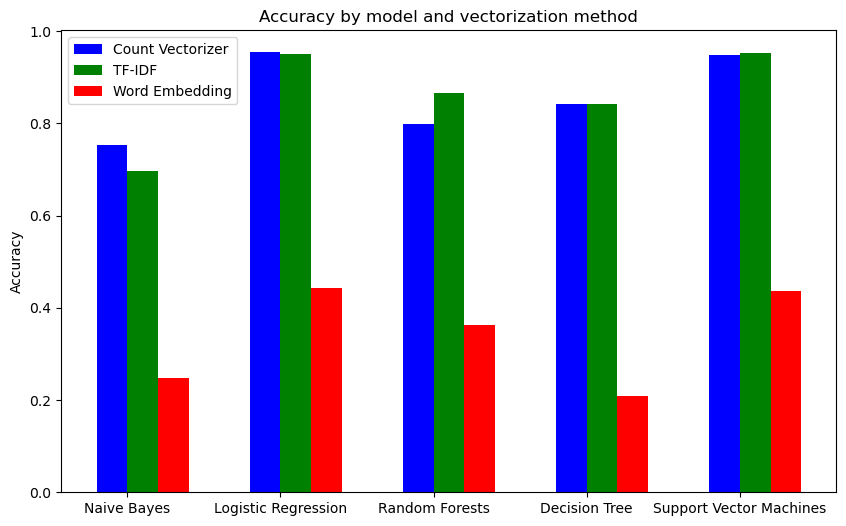

In [118]:
performance_dict_1 = create_performance_dict(count_vector_acc_1, tfidf_vector_acc_1, embedding_vector_acc_1)
plot_results(performance_dict_1)

## Preprocess2 = Preprocess1 + remove stop words

In [24]:
def preprocess2(text):
    # Lowercase the text
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    return tokens

In [25]:
df['proc_tweet2'] = df['tweet'].apply(preprocess2)
df

C:\Users\admin\AppData\Local\Temp\ipykernel_2480\3496721662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['proc_tweet2'] = df['tweet'].apply(preprocess2)


,tweet,topic,proc_tweet1,proc_tweet2
0,Next up on the docket: free every black man un...,legalization,"[next, up, on, the, docket, :, free, every, bl...","[next, docket, :, free, every, black, man, unf..."
1,Shout out to the hard work of grassroots organ...,legalization,"[shout, out, to, the, hard, work, of, grassroo...","[shout, hard, work, grassroots, organizers, su..."
2,i still can't get over the democrats overwhelm...,legalization,"[i, still, ca, n't, get, over, the, democrats,...","[still, ca, n't, get, democrats, overwhelmingl..."
3,The House has voted to decriminalize marijuana...,legalization,"[the, house, has, voted, to, decriminalize, ma...","[house, voted, decriminalize, marijuana, expun..."
4,Good morning! 57% of Americans and 78% of Demo...,legalization,"[good, morning, !, 57, %, of, americans, and, ...","[good, morning, !, 57, %, americans, 78, %, de..."
...,...,...,...,...
152451,Soros Foundation promoted drug legalization wo...,drug legalization,"[soros, foundation, promoted, drug, legalizati...","[soros, foundation, promoted, drug, legalizati..."
152452,Waiting to hear @TexasGOP say anything about #...,drug legalization,"[waiting, to, hear, @, texasgop, say, anything...","[waiting, hear, @, texasgop, say, anything, #,..."
152453,"""Police work for #narcos because they pay bett...",drug legalization,"[``, police, work, for, #, narcos, because, th...","[``, police, work, #, narcos, pay, better, '',..."
152454,Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...,drug legalization,"[govt-funded, anti-drug, program, “, d.a.r.e.,...","[govt-funded, anti-drug, program, “, d.a.r.e.,..."


In [26]:
# Define the models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Random Forests': RandomForestClassifier(n_jobs=-1, max_depth=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Support Vector Machines': svm.LinearSVC(max_iter=2000)
}

### Count Vectorizer (Bag of Words)

In [27]:
# Fit and transform the data
X_count_2 = CountVectorizer().fit_transform(df['proc_tweet2'].apply(lambda x: ' '.join(x)))

In [28]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_count_2, y, test_size=0.25, random_state=42)

In [29]:
count_vector_acc_2 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.89      0.89      0.89      1992
              cannabis       0.84      0.45      0.59      2524
       cannabis policy       0.64      0.89      0.75      2509
         decriminalize       0.88      0.86      0.87      2468
drug decriminalization       0.79      0.87      0.83      2502
     drug legalization       0.56      0.84      0.67      2541
           drug policy       0.92      0.82      0.86      2524
           gun control       0.98      1.00      0.99      2503
          legalization       0.69      0.69      0.69      2464
            legalizeit       0.92      0.73      0.81      2462
             marijuana       0.82      0.51      0.63      2483
      medical cannabis       0.67      0.82      0.74      2524
     medical marijuana       0.74      0.77      0.76      2457
    psilocybin therapy       0.97     

### TF-IDF

In [31]:
# Fit and transform the data
X_tfidf_2 = TfidfVectorizer().fit_transform(df['proc_tweet2'].apply(lambda x: ' '.join(x)))

In [32]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_2, y, test_size=0.25, random_state=42)

In [33]:
tfidf_vector_acc_2 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.91      0.77      0.83      1992
              cannabis       0.81      0.43      0.56      2524
       cannabis policy       0.61      0.78      0.69      2509
         decriminalize       0.80      0.81      0.80      2468
drug decriminalization       0.67      0.83      0.74      2502
     drug legalization       0.50      0.75      0.60      2541
           drug policy       0.84      0.73      0.78      2524
           gun control       0.93      0.99      0.96      2503
          legalization       0.61      0.62      0.62      2464
            legalizeit       0.90      0.71      0.79      2462
             marijuana       0.73      0.42      0.53      2483
      medical cannabis       0.65      0.71      0.68      2524
     medical marijuana       0.69      0.71      0.70      2457
    psilocybin therapy       0.98     

### Word Embeddings (Spacy)

In [35]:
X_embedding_2 = df['proc_tweet2'].apply(lambda x: nlp(' '.join(x)).vector)
# Convert the Series to a 2D array
X_embedding_2 = np.array(X_embedding_2.to_list())

In [36]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_embedding_2, y, test_size=0.25, random_state=42)

In [37]:
# Define the models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Random Forests': RandomForestClassifier(n_jobs=-1, max_depth=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Support Vector Machines': svm.LinearSVC(max_iter=2000)
}

In [38]:
embedding_vector_acc_2 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.29      0.18      0.22      1992
              cannabis       0.50      0.30      0.38      2524
       cannabis policy       0.17      0.38      0.23      2509
         decriminalize       0.24      0.08      0.12      2468
drug decriminalization       0.25      0.22      0.24      2502
     drug legalization       0.19      0.29      0.23      2541
           drug policy       0.25      0.20      0.22      2524
           gun control       0.28      0.15      0.20      2503
          legalization       0.22      0.07      0.11      2464
            legalizeit       0.45      0.60      0.51      2462
             marijuana       0.22      0.21      0.21      2483
      medical cannabis       0.22      0.21      0.22      2524
     medical marijuana       0.24      0.40      0.30      2457
    psilocybin therapy       0.24     

### Accuracy by model and vectorization

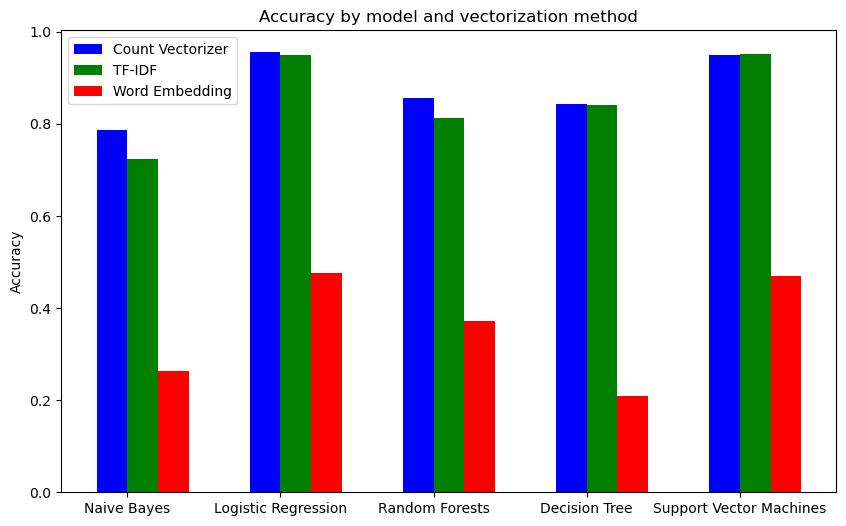

In [119]:
performance_dict_2 = create_performance_dict(count_vector_acc_2, tfidf_vector_acc_2, embedding_vector_acc_2)
plot_results(performance_dict_2)

## Preprocess3 = Preprocess2 + remove URL and special characters

In [41]:
def preprocess3(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    
    # Remove single characters left as a result of removing special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove any single characters at the start of the text
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    
    # Substitute multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Remove all characters except words and digits
    text = re.sub(r"[^\w\s\d]", "", text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    return tokens

In [42]:
df['proc_tweet3'] = df['tweet'].apply(preprocess3)
df

C:\Users\admin\AppData\Local\Temp\ipykernel_2480\3431242967.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['proc_tweet3'] = df['tweet'].apply(preprocess3)


,tweet,topic,proc_tweet1,proc_tweet2,proc_tweet3
0,Next up on the docket: free every black man un...,legalization,"[next, up, on, the, docket, :, free, every, bl...","[next, docket, :, free, every, black, man, unf...","[next, docket, free, every, black, man, unfair..."
1,Shout out to the hard work of grassroots organ...,legalization,"[shout, out, to, the, hard, work, of, grassroo...","[shout, hard, work, grassroots, organizers, su...","[shout, hard, work, grassroots, organizers, su..."
2,i still can't get over the democrats overwhelm...,legalization,"[i, still, ca, n't, get, over, the, democrats,...","[still, ca, n't, get, democrats, overwhelmingl...","[still, get, democrats, overwhelmingly, voting..."
3,The House has voted to decriminalize marijuana...,legalization,"[the, house, has, voted, to, decriminalize, ma...","[house, voted, decriminalize, marijuana, expun...","[house, voted, decriminalize, marijuana, expun..."
4,Good morning! 57% of Americans and 78% of Demo...,legalization,"[good, morning, !, 57, %, of, americans, and, ...","[good, morning, !, 57, %, americans, 78, %, de...","[good, morning, 57, americans, 78, democrats, ..."
...,...,...,...,...,...
152451,Soros Foundation promoted drug legalization wo...,drug legalization,"[soros, foundation, promoted, drug, legalizati...","[soros, foundation, promoted, drug, legalizati...","[soros, foundation, promoted, drug, legalizati..."
152452,Waiting to hear @TexasGOP say anything about #...,drug legalization,"[waiting, to, hear, @, texasgop, say, anything...","[waiting, hear, @, texasgop, say, anything, #,...","[waiting, hear, texasgop, say, anything, drugl..."
152453,"""Police work for #narcos because they pay bett...",drug legalization,"[``, police, work, for, #, narcos, because, th...","[``, police, work, #, narcos, pay, better, '',...","[police, work, narcos, pay, better, interview,..."
152454,Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...,drug legalization,"[govt-funded, anti-drug, program, “, d.a.r.e.,...","[govt-funded, anti-drug, program, “, d.a.r.e.,...","[govt, funded, anti, drug, program, e, called,..."


In [43]:
# Define the models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Random Forests': RandomForestClassifier(n_jobs=-1, max_depth=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Support Vector Machines': svm.LinearSVC(max_iter=2000)
}

### Count Vectorizer (Bag of Words)

In [44]:
# Fit and transform the data
X_count_3 = CountVectorizer().fit_transform(df['proc_tweet3'].apply(lambda x: ' '.join(x)))

In [45]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_count_3, y, test_size=0.25, random_state=42)

In [46]:
count_vector_acc_3 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.89      0.91      0.90      1992
              cannabis       0.84      0.44      0.58      2524
       cannabis policy       0.66      0.89      0.75      2509
         decriminalize       0.88      0.86      0.87      2468
drug decriminalization       0.79      0.87      0.83      2502
     drug legalization       0.57      0.84      0.68      2541
           drug policy       0.91      0.82      0.87      2524
           gun control       0.98      1.00      0.99      2503
          legalization       0.68      0.68      0.68      2464
            legalizeit       0.92      0.73      0.82      2462
             marijuana       0.79      0.50      0.61      2483
      medical cannabis       0.68      0.83      0.74      2524
     medical marijuana       0.75      0.77      0.76      2457
    psilocybin therapy       0.95     

### TF-IDF

In [48]:
# Fit and transform the data
X_tfidf_3 = TfidfVectorizer().fit_transform(df['proc_tweet3'].apply(lambda x: ' '.join(x)))

In [49]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_3, y, test_size=0.25, random_state=42)

In [50]:
tfidf_vector_acc_3 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.89      0.79      0.84      1992
              cannabis       0.80      0.43      0.56      2524
       cannabis policy       0.63      0.77      0.69      2509
         decriminalize       0.79      0.82      0.80      2468
drug decriminalization       0.68      0.82      0.74      2502
     drug legalization       0.52      0.72      0.60      2541
           drug policy       0.85      0.74      0.79      2524
           gun control       0.94      0.99      0.96      2503
          legalization       0.60      0.64      0.62      2464
            legalizeit       0.90      0.71      0.79      2462
             marijuana       0.67      0.44      0.53      2483
      medical cannabis       0.65      0.71      0.68      2524
     medical marijuana       0.66      0.72      0.69      2457
    psilocybin therapy       0.99     

### Word Embeddings (Spacy)

In [52]:
X_embedding_3 = df['proc_tweet3'].apply(lambda x: nlp(' '.join(x)).vector)
# Convert the Series to a 2D array
X_embedding_3 = np.array(X_embedding_3.to_list())

In [53]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_embedding_3, y, test_size=0.25, random_state=42)

In [54]:
# Define the models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Random Forests': RandomForestClassifier(n_jobs=-1, max_depth=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Support Vector Machines': svm.LinearSVC(max_iter=2000)
}

In [55]:
embedding_vector_acc_3 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.26      0.25      0.26      1992
              cannabis       0.53      0.22      0.31      2524
       cannabis policy       0.19      0.40      0.25      2509
         decriminalize       0.28      0.16      0.21      2468
drug decriminalization       0.24      0.38      0.29      2502
     drug legalization       0.21      0.21      0.21      2541
           drug policy       0.25      0.26      0.25      2524
           gun control       0.42      0.18      0.25      2503
          legalization       0.27      0.08      0.12      2464
            legalizeit       0.45      0.49      0.47      2462
             marijuana       0.30      0.23      0.26      2483
      medical cannabis       0.33      0.24      0.28      2524
     medical marijuana       0.31      0.46      0.37      2457
    psilocybin therapy       0.39     

### Accuracy by model and vectorization

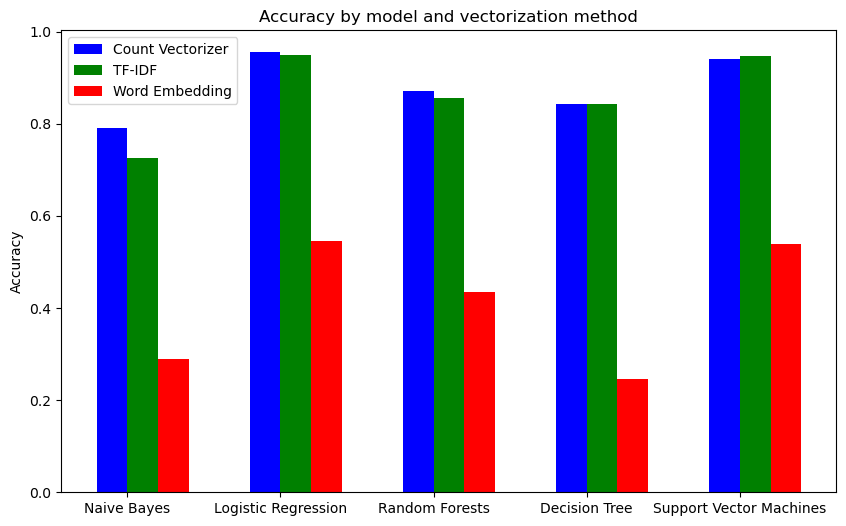

In [120]:
performance_dict_3 = create_performance_dict(count_vector_acc_3, tfidf_vector_acc_3, embedding_vector_acc_3)
plot_results(performance_dict_3)

## Preprocess4 = Preprocess3 + remove digits

In [57]:
def preprocess4(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    
    # Remove single characters left as a result of removing special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove any single characters at the start of the text
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    
    # Substitute multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Remove all characters except words
    text = re.sub(r"[^\w\s]|[\d]", "", text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    return tokens


In [58]:
df['proc_tweet4'] = df['tweet'].apply(preprocess4)
df

C:\Users\admin\AppData\Local\Temp\ipykernel_2480\3247191118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['proc_tweet4'] = df['tweet'].apply(preprocess4)


,tweet,topic,proc_tweet1,proc_tweet2,proc_tweet3,proc_tweet4
0,Next up on the docket: free every black man un...,legalization,"[next, up, on, the, docket, :, free, every, bl...","[next, docket, :, free, every, black, man, unf...","[next, docket, free, every, black, man, unfair...","[next, docket, free, every, black, man, unfair..."
1,Shout out to the hard work of grassroots organ...,legalization,"[shout, out, to, the, hard, work, of, grassroo...","[shout, hard, work, grassroots, organizers, su...","[shout, hard, work, grassroots, organizers, su...","[shout, hard, work, grassroots, organizers, su..."
2,i still can't get over the democrats overwhelm...,legalization,"[i, still, ca, n't, get, over, the, democrats,...","[still, ca, n't, get, democrats, overwhelmingl...","[still, get, democrats, overwhelmingly, voting...","[still, get, democrats, overwhelmingly, voting..."
3,The House has voted to decriminalize marijuana...,legalization,"[the, house, has, voted, to, decriminalize, ma...","[house, voted, decriminalize, marijuana, expun...","[house, voted, decriminalize, marijuana, expun...","[house, voted, decriminalize, marijuana, expun..."
4,Good morning! 57% of Americans and 78% of Demo...,legalization,"[good, morning, !, 57, %, of, americans, and, ...","[good, morning, !, 57, %, americans, 78, %, de...","[good, morning, 57, americans, 78, democrats, ...","[good, morning, americans, democrats, support,..."
...,...,...,...,...,...,...
152451,Soros Foundation promoted drug legalization wo...,drug legalization,"[soros, foundation, promoted, drug, legalizati...","[soros, foundation, promoted, drug, legalizati...","[soros, foundation, promoted, drug, legalizati...","[soros, foundation, promoted, drug, legalizati..."
152452,Waiting to hear @TexasGOP say anything about #...,drug legalization,"[waiting, to, hear, @, texasgop, say, anything...","[waiting, hear, @, texasgop, say, anything, #,...","[waiting, hear, texasgop, say, anything, drugl...","[waiting, hear, texasgop, say, anything, drugl..."
152453,"""Police work for #narcos because they pay bett...",drug legalization,"[``, police, work, for, #, narcos, because, th...","[``, police, work, #, narcos, pay, better, '',...","[police, work, narcos, pay, better, interview,...","[police, work, narcos, pay, better, interview,..."
152454,Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...,drug legalization,"[govt-funded, anti-drug, program, “, d.a.r.e.,...","[govt-funded, anti-drug, program, “, d.a.r.e.,...","[govt, funded, anti, drug, program, e, called,...","[govt, funded, anti, drug, program, e, called,..."


In [59]:
# Define the models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Random Forests': RandomForestClassifier(n_jobs=-1, max_depth=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Support Vector Machines': svm.LinearSVC(max_iter=2000)
}

### Count Vectorizer (Bag of Words)

In [60]:
# Fit and transform the data
X_count_4 = CountVectorizer().fit_transform(df['proc_tweet4'].apply(lambda x: ' '.join(x)))

In [61]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_count_4, y, test_size=0.25, random_state=42)

In [62]:
count_vector_acc_4 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.89      0.91      0.90      1992
              cannabis       0.84      0.44      0.57      2524
       cannabis policy       0.66      0.89      0.75      2509
         decriminalize       0.88      0.87      0.87      2468
drug decriminalization       0.79      0.87      0.83      2502
     drug legalization       0.57      0.84      0.68      2541
           drug policy       0.91      0.82      0.87      2524
           gun control       0.98      1.00      0.99      2503
          legalization       0.68      0.68      0.68      2464
            legalizeit       0.92      0.73      0.82      2462
             marijuana       0.80      0.50      0.61      2483
      medical cannabis       0.68      0.82      0.74      2524
     medical marijuana       0.74      0.77      0.76      2457
    psilocybin therapy       0.94     

### TF-IDF

In [64]:
# Fit and transform the data
X_tfidf_4 = TfidfVectorizer().fit_transform(df['proc_tweet4'].apply(lambda x: ' '.join(x)))

In [65]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_4, y, test_size=0.25, random_state=42)

In [66]:
tfidf_vector_acc_4 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.89      0.79      0.83      1992
              cannabis       0.80      0.43      0.56      2524
       cannabis policy       0.63      0.77      0.69      2509
         decriminalize       0.78      0.82      0.80      2468
drug decriminalization       0.68      0.82      0.74      2502
     drug legalization       0.52      0.72      0.60      2541
           drug policy       0.85      0.73      0.79      2524
           gun control       0.94      0.99      0.96      2503
          legalization       0.60      0.63      0.62      2464
            legalizeit       0.90      0.71      0.79      2462
             marijuana       0.67      0.43      0.52      2483
      medical cannabis       0.65      0.71      0.68      2524
     medical marijuana       0.66      0.72      0.69      2457
    psilocybin therapy       0.98     

### Word Embeddings (Spacy)

In [68]:
# Convert each tweet to a vector and store them in a list
X_embedding_4 = df['proc_tweet4'].apply(lambda x: nlp(' '.join(x)).vector).tolist()
# Pad the vectors to ensure they all have the same length
X_embedding_4 = pad_sequences(X_embedding_4, dtype='float32', padding='post')

In [69]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_embedding_4, y, test_size=0.25, random_state=42)

In [70]:
# Define the models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Random Forests': RandomForestClassifier(n_jobs=-1, max_depth=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Support Vector Machines': svm.LinearSVC(max_iter=2000)
}

In [71]:
embedding_vector_acc_4 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.26      0.24      0.25      1992
              cannabis       0.54      0.23      0.33      2524
       cannabis policy       0.19      0.40      0.26      2509
         decriminalize       0.28      0.17      0.21      2468
drug decriminalization       0.24      0.38      0.29      2502
     drug legalization       0.20      0.20      0.20      2541
           drug policy       0.23      0.26      0.24      2524
           gun control       0.44      0.18      0.26      2503
          legalization       0.28      0.09      0.13      2464
            legalizeit       0.46      0.50      0.48      2462
             marijuana       0.30      0.22      0.26      2483
      medical cannabis       0.33      0.23      0.27      2524
     medical marijuana       0.29      0.44      0.35      2457
    psilocybin therapy       0.37     

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report for Support Vector Machines:

                        precision    recall  f1-score   support

          MDMA therapy       0.58      0.64      0.61      1992
              cannabis       0.55      0.40      0.46      2524
       cannabis policy       0.49      0.35      0.41      2509
         decriminalize       0.54      0.62      0.58      2468
drug decriminalization       0.50      0.66      0.57      2502
     drug legalization       0.47      0.27      0.34      2541
           drug policy       0.50      0.45      0.48      2524
           gun control       0.56      0.69      0.62      2503
          legalization       0.46      0.43      0.45      2464
            legalizeit       0.60      0.76      0.67      2462
             marijuana       0.51      0.39      0.44      2483
      medical cannabis       0.51      0.45      0.48      2524
     medical marijuana       0.56      0.68      0.62      2457
    psilocybin therapy       0.61      0.53      0.

### Accuracy by model and vectorization

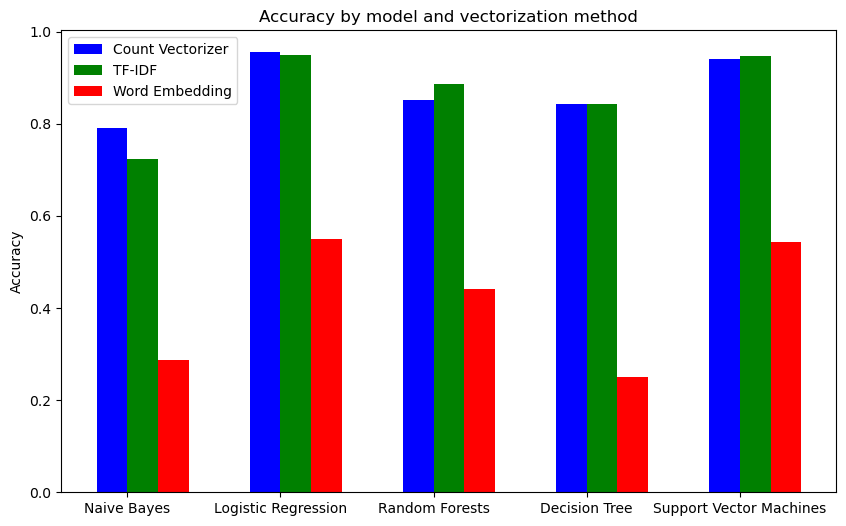

In [121]:
performance_dict_4 = create_performance_dict(count_vector_acc_4, tfidf_vector_acc_4, embedding_vector_acc_4)
plot_results(performance_dict_4)

## Preprocess5 = Preprocess4 + using stemming

In [73]:
def preprocess5(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    
    # Remove single characters left as a result of removing special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove any single characters at the start of the text
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    
    # Substitute multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Remove all characters except words
    text = re.sub(r"[^\w\s]|[\d]", "", text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Apply stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

In [74]:
df['proc_tweet5'] = df['tweet'].apply(preprocess5)
df

C:\Users\admin\AppData\Local\Temp\ipykernel_2480\2204074163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['proc_tweet5'] = df['tweet'].apply(preprocess5)


,tweet,topic,proc_tweet1,proc_tweet2,proc_tweet3,proc_tweet4,proc_tweet5
0,Next up on the docket: free every black man un...,legalization,"[next, up, on, the, docket, :, free, every, bl...","[next, docket, :, free, every, black, man, unf...","[next, docket, free, every, black, man, unfair...","[next, docket, free, every, black, man, unfair...","[next, docket, free, everi, black, man, unfair..."
1,Shout out to the hard work of grassroots organ...,legalization,"[shout, out, to, the, hard, work, of, grassroo...","[shout, hard, work, grassroots, organizers, su...","[shout, hard, work, grassroots, organizers, su...","[shout, hard, work, grassroots, organizers, su...","[shout, hard, work, grassroot, organ, success,..."
2,i still can't get over the democrats overwhelm...,legalization,"[i, still, ca, n't, get, over, the, democrats,...","[still, ca, n't, get, democrats, overwhelmingl...","[still, get, democrats, overwhelmingly, voting...","[still, get, democrats, overwhelmingly, voting...","[still, get, democrat, overwhelmingli, vote, m..."
3,The House has voted to decriminalize marijuana...,legalization,"[the, house, has, voted, to, decriminalize, ma...","[house, voted, decriminalize, marijuana, expun...","[house, voted, decriminalize, marijuana, expun...","[house, voted, decriminalize, marijuana, expun...","[hous, vote, decrimin, marijuana, expung, nonv..."
4,Good morning! 57% of Americans and 78% of Demo...,legalization,"[good, morning, !, 57, %, of, americans, and, ...","[good, morning, !, 57, %, americans, 78, %, de...","[good, morning, 57, americans, 78, democrats, ...","[good, morning, americans, democrats, support,...","[good, morn, american, democrat, support, medi..."
...,...,...,...,...,...,...,...
152451,Soros Foundation promoted drug legalization wo...,drug legalization,"[soros, foundation, promoted, drug, legalizati...","[soros, foundation, promoted, drug, legalizati...","[soros, foundation, promoted, drug, legalizati...","[soros, foundation, promoted, drug, legalizati...","[soro, foundat, promot, drug, legal, worldwid,..."
152452,Waiting to hear @TexasGOP say anything about #...,drug legalization,"[waiting, to, hear, @, texasgop, say, anything...","[waiting, hear, @, texasgop, say, anything, #,...","[waiting, hear, texasgop, say, anything, drugl...","[waiting, hear, texasgop, say, anything, drugl...","[wait, hear, texasgop, say, anyth, drugleg, st..."
152453,"""Police work for #narcos because they pay bett...",drug legalization,"[``, police, work, for, #, narcos, because, th...","[``, police, work, #, narcos, pay, better, '',...","[police, work, narcos, pay, better, interview,...","[police, work, narcos, pay, better, interview,...","[polic, work, narco, pay, better, interview, d..."
152454,Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...,drug legalization,"[govt-funded, anti-drug, program, “, d.a.r.e.,...","[govt-funded, anti-drug, program, “, d.a.r.e.,...","[govt, funded, anti, drug, program, e, called,...","[govt, funded, anti, drug, program, e, called,...","[govt, fund, anti, drug, program, e, call, leg..."


In [75]:
# Define the models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Random Forests': RandomForestClassifier(n_jobs=-1, max_depth=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Support Vector Machines': svm.LinearSVC(max_iter=2000)
}

### Count Vectorizer (Bag of Words)

In [76]:
# Fit and transform the data
X_count_5 = CountVectorizer().fit_transform(df['proc_tweet5'].apply(lambda x: ' '.join(x)))

In [77]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_count_5, y, test_size=0.25, random_state=42)

In [78]:
count_vector_acc_5 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.88      0.90      0.89      1992
              cannabis       0.83      0.42      0.56      2524
       cannabis policy       0.64      0.87      0.74      2509
         decriminalize       0.77      0.71      0.74      2468
drug decriminalization       0.68      0.81      0.74      2502
     drug legalization       0.54      0.80      0.65      2541
           drug policy       0.90      0.80      0.84      2524
           gun control       0.98      0.99      0.99      2503
          legalization       0.59      0.63      0.61      2464
            legalizeit       0.92      0.72      0.81      2462
             marijuana       0.77      0.45      0.56      2483
      medical cannabis       0.68      0.82      0.74      2524
     medical marijuana       0.74      0.75      0.75      2457
    psilocybin therapy       0.94     

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report for Support Vector Machines:

                        precision    recall  f1-score   support

          MDMA therapy       0.97      0.97      0.97      1992
              cannabis       0.87      0.84      0.86      2524
       cannabis policy       0.92      0.92      0.92      2509
         decriminalize       0.78      0.82      0.80      2468
drug decriminalization       0.80      0.79      0.80      2502
     drug legalization       0.81      0.79      0.80      2541
           drug policy       0.92      0.93      0.93      2524
           gun control       0.99      1.00      0.99      2503
          legalization       0.77      0.73      0.75      2464
            legalizeit       0.98      0.98      0.98      2462
             marijuana       0.81      0.77      0.79      2483
      medical cannabis       0.90      0.92      0.91      2524
     medical marijuana       0.86      0.90      0.88      2457
    psilocybin therapy       0.93      0.96      0.

### TF-IDF

In [80]:
# Fit and transform the data
X_tfidf_5 = TfidfVectorizer().fit_transform(df['proc_tweet5'].apply(lambda x: ' '.join(x)))

In [81]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_5, y, test_size=0.25, random_state=42)

In [82]:
tfidf_vector_acc_5 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.89      0.77      0.83      1992
              cannabis       0.80      0.42      0.55      2524
       cannabis policy       0.60      0.77      0.67      2509
         decriminalize       0.68      0.68      0.68      2468
drug decriminalization       0.60      0.74      0.66      2502
     drug legalization       0.48      0.66      0.56      2541
           drug policy       0.82      0.71      0.76      2524
           gun control       0.92      0.99      0.95      2503
          legalization       0.52      0.56      0.54      2464
            legalizeit       0.90      0.70      0.79      2462
             marijuana       0.64      0.40      0.49      2483
      medical cannabis       0.65      0.71      0.68      2524
     medical marijuana       0.65      0.70      0.68      2457
    psilocybin therapy       0.98     

### Word Embeddings (Spacy)

In [84]:
# Convert each tweet to a vector and store them in a list
X_embedding_5 = df['proc_tweet5'].apply(lambda x: nlp(' '.join(x)).vector).tolist()
# Pad the vectors to ensure they all have the same length
X_embedding_5 = pad_sequences(X_embedding_5, dtype='float32', padding='post')

In [85]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_embedding_5, y, test_size=0.25, random_state=42)

In [86]:
# Define the models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Random Forests': RandomForestClassifier(n_jobs=-1, max_depth=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Support Vector Machines': svm.LinearSVC(max_iter=2000)
}

In [87]:
embedding_vector_acc_5 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.32      0.44      0.37      1992
              cannabis       0.49      0.31      0.38      2524
       cannabis policy       0.20      0.42      0.27      2509
         decriminalize       0.39      0.11      0.17      2468
drug decriminalization       0.26      0.37      0.31      2502
     drug legalization       0.21      0.43      0.28      2541
           drug policy       0.21      0.22      0.21      2524
           gun control       0.36      0.36      0.36      2503
          legalization       0.28      0.22      0.25      2464
            legalizeit       0.46      0.20      0.27      2462
             marijuana       0.32      0.23      0.27      2483
      medical cannabis       0.50      0.17      0.26      2524
     medical marijuana       0.34      0.38      0.36      2457
    psilocybin therapy       0.42     

### Accuracy by model and vectorization

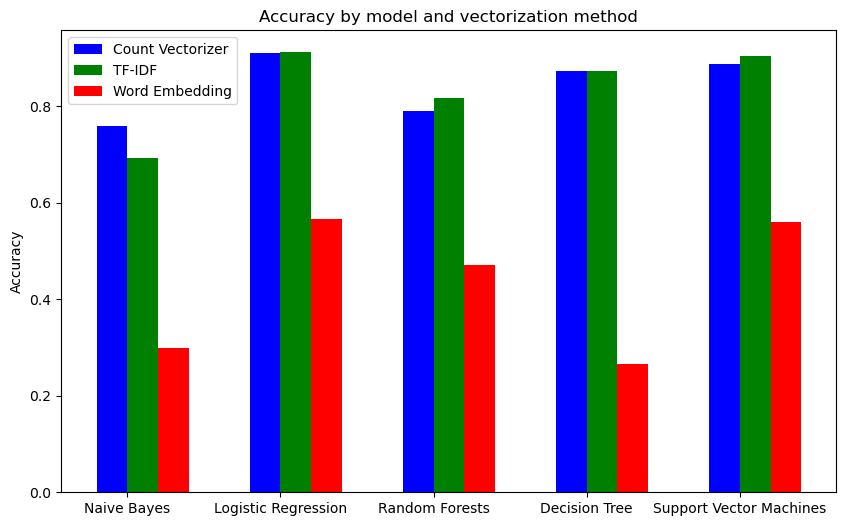

In [122]:
performance_dict_5 = create_performance_dict(count_vector_acc_5, tfidf_vector_acc_5, embedding_vector_acc_5)
plot_results(performance_dict_5)

## Preprocess6 = Preprocess4 + using lemmatization

In [89]:
def preprocess6(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    
    # Remove single characters left as a result of removing special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove any single characters at the start of the text
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    
    # Substitute multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Remove all characters except words
    text = re.sub(r"[^\w\s]|[\d]", "", text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [90]:
df['proc_tweet6'] = df['tweet'].apply(preprocess6)
df

C:\Users\admin\AppData\Local\Temp\ipykernel_2480\477395253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['proc_tweet6'] = df['tweet'].apply(preprocess6)


,tweet,topic,proc_tweet1,proc_tweet2,proc_tweet3,proc_tweet4,proc_tweet5,proc_tweet6
0,Next up on the docket: free every black man un...,legalization,"[next, up, on, the, docket, :, free, every, bl...","[next, docket, :, free, every, black, man, unf...","[next, docket, free, every, black, man, unfair...","[next, docket, free, every, black, man, unfair...","[next, docket, free, everi, black, man, unfair...","[next, docket, free, every, black, man, unfair..."
1,Shout out to the hard work of grassroots organ...,legalization,"[shout, out, to, the, hard, work, of, grassroo...","[shout, hard, work, grassroots, organizers, su...","[shout, hard, work, grassroots, organizers, su...","[shout, hard, work, grassroots, organizers, su...","[shout, hard, work, grassroot, organ, success,...","[shout, hard, work, grassroots, organizer, suc..."
2,i still can't get over the democrats overwhelm...,legalization,"[i, still, ca, n't, get, over, the, democrats,...","[still, ca, n't, get, democrats, overwhelmingl...","[still, get, democrats, overwhelmingly, voting...","[still, get, democrats, overwhelmingly, voting...","[still, get, democrat, overwhelmingli, vote, m...","[still, get, democrat, overwhelmingly, voting,..."
3,The House has voted to decriminalize marijuana...,legalization,"[the, house, has, voted, to, decriminalize, ma...","[house, voted, decriminalize, marijuana, expun...","[house, voted, decriminalize, marijuana, expun...","[house, voted, decriminalize, marijuana, expun...","[hous, vote, decrimin, marijuana, expung, nonv...","[house, voted, decriminalize, marijuana, expun..."
4,Good morning! 57% of Americans and 78% of Demo...,legalization,"[good, morning, !, 57, %, of, americans, and, ...","[good, morning, !, 57, %, americans, 78, %, de...","[good, morning, 57, americans, 78, democrats, ...","[good, morning, americans, democrats, support,...","[good, morn, american, democrat, support, medi...","[good, morning, american, democrat, support, m..."
...,...,...,...,...,...,...,...,...
152451,Soros Foundation promoted drug legalization wo...,drug legalization,"[soros, foundation, promoted, drug, legalizati...","[soros, foundation, promoted, drug, legalizati...","[soros, foundation, promoted, drug, legalizati...","[soros, foundation, promoted, drug, legalizati...","[soro, foundat, promot, drug, legal, worldwid,...","[soros, foundation, promoted, drug, legalizati..."
152452,Waiting to hear @TexasGOP say anything about #...,drug legalization,"[waiting, to, hear, @, texasgop, say, anything...","[waiting, hear, @, texasgop, say, anything, #,...","[waiting, hear, texasgop, say, anything, drugl...","[waiting, hear, texasgop, say, anything, drugl...","[wait, hear, texasgop, say, anyth, drugleg, st...","[waiting, hear, texasgop, say, anything, drugl..."
152453,"""Police work for #narcos because they pay bett...",drug legalization,"[``, police, work, for, #, narcos, because, th...","[``, police, work, #, narcos, pay, better, '',...","[police, work, narcos, pay, better, interview,...","[police, work, narcos, pay, better, interview,...","[polic, work, narco, pay, better, interview, d...","[police, work, narcos, pay, better, interview,..."
152454,Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...,drug legalization,"[govt-funded, anti-drug, program, “, d.a.r.e.,...","[govt-funded, anti-drug, program, “, d.a.r.e.,...","[govt, funded, anti, drug, program, e, called,...","[govt, funded, anti, drug, program, e, called,...","[govt, fund, anti, drug, program, e, call, leg...","[govt, funded, anti, drug, program, e, called,..."


In [152]:
# Define the models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Random Forests': RandomForestClassifier(n_jobs=-1, max_depth=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Support Vector Machines': svm.LinearSVC(max_iter=2000)
}

### Count Vectorizer (Bag of Words)

In [92]:
# Fit and transform the data
X_count_6 = CountVectorizer().fit_transform(df['proc_tweet6'].apply(lambda x: ' '.join(x)))

In [93]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_count_6, y, test_size=0.25, random_state=42)

In [94]:
count_vector_acc_6 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.89      0.91      0.90      1992
              cannabis       0.84      0.44      0.58      2524
       cannabis policy       0.65      0.87      0.74      2509
         decriminalize       0.88      0.87      0.87      2468
drug decriminalization       0.78      0.88      0.83      2502
     drug legalization       0.56      0.84      0.67      2541
           drug policy       0.91      0.80      0.85      2524
           gun control       0.98      1.00      0.99      2503
          legalization       0.68      0.68      0.68      2464
            legalizeit       0.92      0.73      0.82      2462
             marijuana       0.80      0.49      0.61      2483
      medical cannabis       0.68      0.82      0.74      2524
     medical marijuana       0.74      0.77      0.76      2457
    psilocybin therapy       0.95     

### TF-IDF

In [96]:
# Fit and transform the data
X_tfidf_6 = TfidfVectorizer().fit_transform(df['proc_tweet6'].apply(lambda x: ' '.join(x)))

In [97]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_6, y, test_size=0.25, random_state=42)

In [98]:
tfidf_vector_acc_6 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.90      0.79      0.84      1992
              cannabis       0.80      0.43      0.56      2524
       cannabis policy       0.62      0.77      0.68      2509
         decriminalize       0.79      0.82      0.80      2468
drug decriminalization       0.68      0.82      0.74      2502
     drug legalization       0.51      0.71      0.59      2541
           drug policy       0.84      0.71      0.77      2524
           gun control       0.93      0.99      0.96      2503
          legalization       0.60      0.63      0.61      2464
            legalizeit       0.90      0.71      0.79      2462
             marijuana       0.67      0.43      0.52      2483
      medical cannabis       0.64      0.70      0.67      2524
     medical marijuana       0.65      0.72      0.69      2457
    psilocybin therapy       0.98     

### Word Embeddings (Spacy)

In [100]:
# Convert each tweet to a vector and store them in a list
X_embedding_6 = df['proc_tweet6'].apply(lambda x: nlp(' '.join(x)).vector).tolist()
# Pad the vectors to ensure they all have the same length
X_embedding_6 = pad_sequences(X_embedding_6, dtype='float32', padding='post')

In [101]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_embedding_6, y, test_size=0.25, random_state=42)

In [102]:
# Define the models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Random Forests': RandomForestClassifier(n_jobs=-1, max_depth=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Support Vector Machines': svm.LinearSVC(max_iter=2000)
}

In [103]:
embedding_vector_acc_6 = train_and_evaluate(models)


Training Naive Bayes...
Classification Report for Naive Bayes:

                        precision    recall  f1-score   support

          MDMA therapy       0.23      0.29      0.26      1992
              cannabis       0.51      0.24      0.32      2524
       cannabis policy       0.18      0.43      0.26      2509
         decriminalize       0.28      0.16      0.20      2468
drug decriminalization       0.30      0.34      0.32      2502
     drug legalization       0.23      0.19      0.21      2541
           drug policy       0.22      0.23      0.23      2524
           gun control       0.42      0.20      0.27      2503
          legalization       0.28      0.09      0.13      2464
            legalizeit       0.49      0.47      0.48      2462
             marijuana       0.30      0.21      0.25      2483
      medical cannabis       0.31      0.24      0.27      2524
     medical marijuana       0.27      0.43      0.33      2457
    psilocybin therapy       0.43     

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report for Support Vector Machines:

                        precision    recall  f1-score   support

          MDMA therapy       0.61      0.67      0.64      1992
              cannabis       0.53      0.40      0.46      2524
       cannabis policy       0.49      0.37      0.42      2509
         decriminalize       0.52      0.60      0.56      2468
drug decriminalization       0.51      0.65      0.57      2502
     drug legalization       0.51      0.35      0.41      2541
           drug policy       0.50      0.42      0.46      2524
           gun control       0.59      0.72      0.65      2503
          legalization       0.48      0.44      0.46      2464
            legalizeit       0.61      0.75      0.67      2462
             marijuana       0.52      0.38      0.44      2483
      medical cannabis       0.52      0.45      0.48      2524
     medical marijuana       0.57      0.68      0.62      2457
    psilocybin therapy       0.61      0.55      0.

### Accuracy by model and vectorization

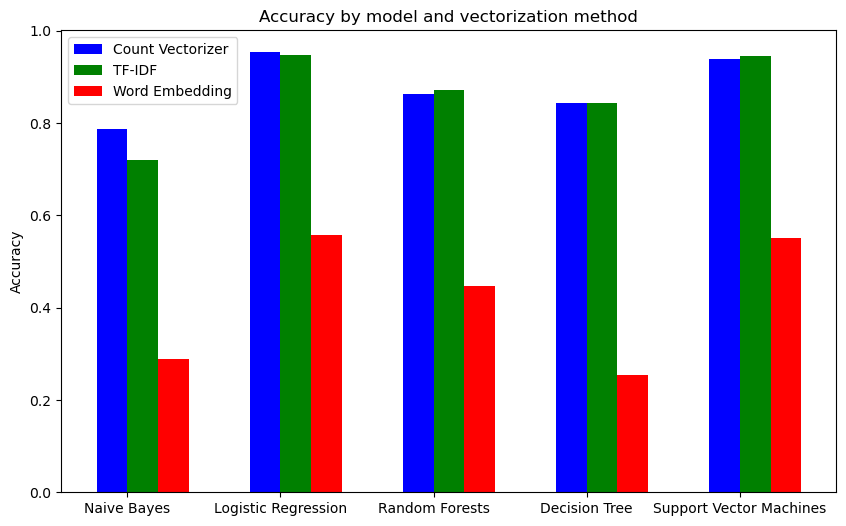

In [123]:
performance_dict_6 = create_performance_dict(count_vector_acc_6, tfidf_vector_acc_6, embedding_vector_acc_6)
plot_results(performance_dict_6)

## Results

In [153]:
# Define the models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Random Forests': RandomForestClassifier(n_jobs=-1, max_depth=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Support Vector Machines': svm.LinearSVC(max_iter=2000)
}

In [127]:
# Define the performance dictionaries for each preprocessing step
performance_dicts = [
    performance_dict_1,
    performance_dict_2,
    performance_dict_3,
    performance_dict_4,
    performance_dict_5,
    performance_dict_6
]

In [147]:
preprocessing_data = {
    'Preprocessing 1': {'Count Vectorizer': X_count_1, 'TF-IDF Vectorizer': X_tfidf_1, 'Word Embedding': X_embedding_1},
    'Preprocessing 2': {'Count Vectorizer': X_count_2, 'TF-IDF Vectorizer': X_tfidf_2, 'Word Embedding': X_embedding_2},
    'Preprocessing 3': {'Count Vectorizer': X_count_3, 'TF-IDF Vectorizer': X_tfidf_3, 'Word Embedding': X_embedding_3},
    'Preprocessing 4': {'Count Vectorizer': X_count_4, 'TF-IDF Vectorizer': X_tfidf_4, 'Word Embedding': X_embedding_4},
    'Preprocessing 5': {'Count Vectorizer': X_count_5, 'TF-IDF Vectorizer': X_tfidf_5, 'Word Embedding': X_embedding_5},
    'Preprocessing 6': {'Count Vectorizer': X_count_6, 'TF-IDF Vectorizer': X_tfidf_6, 'Word Embedding': X_embedding_6}
}

### Top 5 accuracy scores

In [169]:
top_n = top_n_scores(performance_dicts)

Accuracy: 0.9554, Preprocessing Step: Preprocessing 2, Vectorization Method: Count Vectorizer, Model: Logistic Regression
Accuracy: 0.9550, Preprocessing Step: Preprocessing 4, Vectorization Method: Count Vectorizer, Model: Logistic Regression
Accuracy: 0.9550, Preprocessing Step: Preprocessing 3, Vectorization Method: Count Vectorizer, Model: Logistic Regression
Accuracy: 0.9541, Preprocessing Step: Preprocessing 1, Vectorization Method: Count Vectorizer, Model: Logistic Regression
Accuracy: 0.9531, Preprocessing Step: Preprocessing 6, Vectorization Method: Count Vectorizer, Model: Logistic Regression


In [173]:
# Evaluate the top 5 models
best_model, best_y_test, best_y_pred = evaluate_top_n(top_n, preprocessing_data, models, y)

Model: Logistic Regression, Preprocessing Step: Preprocessing 2, Vectorization Method: Count Vectorizer
Accuracy: 0.9554
Precision: 0.9553
Recall: 0.9554
F1 Score: 0.9553
AUC-ROC: 0.9970
Log Loss: 0.1676
Custom Score: 4.6508

Model: Logistic Regression, Preprocessing Step: Preprocessing 4, Vectorization Method: Count Vectorizer
Accuracy: 0.9550
Precision: 0.9550
Recall: 0.9550
F1 Score: 0.9550
AUC-ROC: 0.9968
Log Loss: 0.1717
Custom Score: 4.6452

Model: Logistic Regression, Preprocessing Step: Preprocessing 3, Vectorization Method: Count Vectorizer
Accuracy: 0.9550
Precision: 0.9550
Recall: 0.9550
F1 Score: 0.9549
AUC-ROC: 0.9968
Log Loss: 0.1715
Custom Score: 4.6451

Model: Logistic Regression, Preprocessing Step: Preprocessing 1, Vectorization Method: Count Vectorizer
Accuracy: 0.9541
Precision: 0.9540
Recall: 0.9541
F1 Score: 0.9540
AUC-ROC: 0.9969
Log Loss: 0.1728
Custom Score: 4.6403

Model: Logistic Regression, Preprocessing Step: Preprocessing 6, Vectorization Method: Count Vec

### Best model classification report

In [175]:
print(classification_report(best_y_test, best_y_pred))

                        precision    recall  f1-score   support

          MDMA therapy       0.98      0.97      0.97      1992
              cannabis       0.94      0.92      0.93      2524
       cannabis policy       0.96      0.96      0.96      2509
         decriminalize       0.98      0.99      0.99      2468
drug decriminalization       0.97      0.97      0.97      2502
     drug legalization       0.93      0.94      0.94      2541
           drug policy       0.97      0.97      0.97      2524
           gun control       1.00      1.00      1.00      2503
          legalization       0.92      0.92      0.92      2464
            legalizeit       0.98      0.98      0.98      2462
             marijuana       0.91      0.88      0.89      2483
      medical cannabis       0.93      0.95      0.94      2524
     medical marijuana       0.90      0.92      0.91      2457
    psilocybin therapy       0.97      0.97      0.97      1201
   psychedelic therapy       0.97      

### Best model confusion matrix

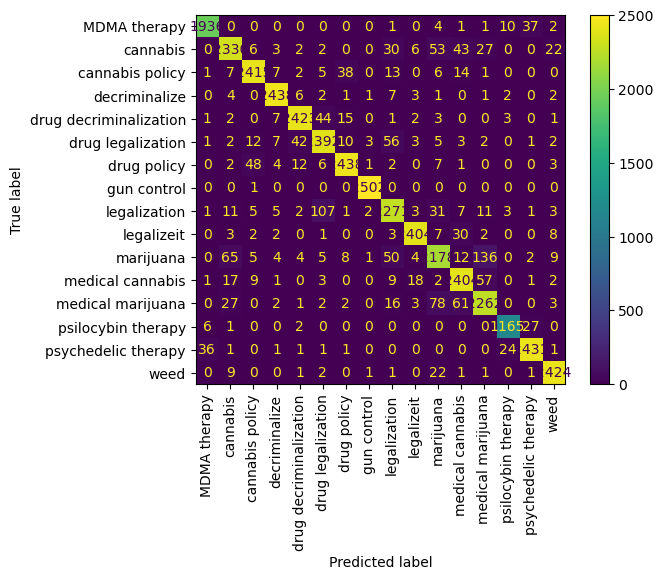

In [186]:
cm = confusion_matrix(best_y_test, best_y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(xticks_rotation='vertical')
plt.show()